In [3]:
#Boiler plate imports
import pandas as pd
import sys
from time import time
import matplotlib.pyplot as plt
import os

#Stats
from sklearn.metrics import roc_curve, auc, precision_recall_curve

#SBND imports
s0 = time()
sys.path.append('/exp/sbnd/app/users/brindenc/analyze_sbnd/pyana')
from sbnd.general import utils
from sbnd.cafclasses.slice import CAFSlice
from sbnd.cafclasses.pfp import PFP

#Constants
from sbnd.numu.numu_constants import *
from sbnd.flux.prism import PRISM_BINS
from sbnd.constants import *
from sbnd.detector.volume import FV,AV

#Plotters
from sbnd.plotlibrary import makeplot
from sbnd.general import plotters

s1 = time()
print(f'SBND imports: {s1-s0:.2f} s')

%load_ext autoreload
%autoreload 2

SBND imports: 0.01 s


## 1. Load DAta

In [4]:
#Constants/variables
CUT_MODE = 'roc'
#DATA_DIR  = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v09_78_04_wc_pandora'
DATA_DIR = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v09_82_02_01_pds_gain'
#DATA_DIR = '/exp/sbnd/data/users/brindenc/ML/test_fcl/debug_trackid/v4'
#FNAME = 'single_processed.df'
#FNAME = 'single_cut_cosmics_processed.df'
#HDR_FNAME = 'single.df'
#FNAME = f'all_processed_{CUT_MODE}.df'
#HDR_FNAME = 'all.df'
FNAME = f'nom_processed_{CUT_MODE}.df'
HDR_FNAME = 'nom.df'
#FNAME = 'test_processed.df'
#HDR_FNAME = 'test.df'
NOM_POT = 0.6e20 # stats for first run
#LABEL = 'SBND Work in Progress\n0.6e20 POT'
LABEL = 'Standard'
PLOT_DIR = f'Plots/reco_{plotters.day}_{CUT_MODE}/roc'
SAVE_PLOT = True

In [5]:
#Get comp samples
FNAME2 = f'pmt20_processed_{CUT_MODE}.df'
HDR_FNAME2 = 'pmt20.df'
LABEL2 = '20% Gain'

FNAME3 = f'pmt50_processed_{CUT_MODE}.df'
HDR_FNAME3 = 'pmt50.df'
LABEL3 = '50% Gain'

labels = [LABEL, LABEL2, LABEL3]
fnames = [FNAME,FNAME2,FNAME3]
hdrs = [HDR_FNAME,HDR_FNAME2,HDR_FNAME3]

In [6]:
os.makedirs(f'{DATA_DIR}/roc_scores',exist_ok=True)

In [7]:
pfps = []
slcs = []


for fname,hdr_fname in zip(fnames,hdrs):
    #Get data and POT
    pfp = PFP.load(f'{DATA_DIR}/{fname}','pfp'
                ,prism_bins=PRISM_BINS
                ,momentum_bins=MOMENTUM_BINS
                ,costheta_bins=COSTHETA_BINS
                ,pot=NOM_POT)
    slc = CAFSlice.load(f'{DATA_DIR}/{fname}','slice'
                        ,prism_bins=PRISM_BINS
                        ,pot=NOM_POT)
    hdr = pd.read_hdf(f'{DATA_DIR}/{hdr_fname}',key='hdr')
    SAMPLE_POT = hdr.pot.sum()

    #Scale to nominal POT
    print(f'--scaled by {NOM_POT/SAMPLE_POT:.2f}')
    pfp.scale_to_pot(NOM_POT,SAMPLE_POT)
    slc.scale_to_pot(NOM_POT,SAMPLE_POT)
    
    #Append to list
    pfps.append(pfp)
    slcs.append(slc)

--scaled by 8.05
--scaling to POT: 7.45e+18 -> 6.00e+19
--scaling to POT: 7.45e+18 -> 6.00e+19
--scaled by 7.97
--scaling to POT: 7.53e+18 -> 6.00e+19
--scaling to POT: 7.53e+18 -> 6.00e+19
--scaled by 8.01
--scaling to POT: 7.49e+18 -> 6.00e+19
--scaling to POT: 7.49e+18 -> 6.00e+19


In [8]:
CUTS = ['cosmic','fv','trk','muon','cont']
for s in slcs:
    pur,eff,f1 = s.get_pur_eff_f1(CUTS)
    print(50*'*')
    print(pur,eff,f1)

**************************************************
[0.22224323 0.66998959 0.81309471 0.85877658 0.92076491 0.89717003] [1.         0.7206205  0.61017594 0.57319694 0.49579174 0.2575995 ] [1.         0.69438333 0.69717004 0.68751007 0.64453142 0.4002713 ]


KeyError: 'muon'

Best ROC:
```
**************************************************
[0.22224323 0.64051238 0.79351257 0.84265354 0.90573035] [1.         0.74992165 0.63027712 0.59027622 0.50841653] [1.         0.69091247 0.70253749 0.69423968 0.65125948]
**************************************************
[0.22232129 0.64181579 0.79369    0.84319781 0.90625   ] [1.         0.74622765 0.62653165 0.58682502 0.50570561] [1.         0.69009467 0.70027366 0.69203031 0.64916447]
**************************************************
[0.2223427  0.64865568 0.79599091 0.84533835 0.90920711] [1.         0.72148122 0.60834131 0.56995257 0.49101516] [1.         0.68313304 0.68962906 0.68085333 0.6376623 ]
```

## 2. Cuts

In [22]:
def make_roc_plot(y,scores,ax=None,fig=None,weights=None,pos_label=0,title='ROC Curve',show_j=False,show_f1=False,label='ROC Curve',**kwargs):
    """
    Make a ROC plot with Youden's J statistic
    """
    fpr, tpr, thresholds = roc_curve(y, scores, pos_label=pos_label, sample_weight=weights)
    j = tpr - fpr # Youden's J statistic
    f1 = 2 * (tpr * (1-fpr)) / (tpr + (1-fpr)) #f1 score
    j_best_score = abs(thresholds[j.argmax()]) #use abs since scores going low to high doesn't work well
    f1_best_score = abs(thresholds[f1.argmax()]) #use abs since scores going low to high doesn't work well
    roc_auc = auc(fpr, tpr)

    #Make plot
    if fig is None and ax is None:
        fig,ax = plt.subplots()
    elif fig is None:
        fig = ax.get_figure()
    elif ax is None:
        ax = fig.gca()
    ax.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:0.2f})',color='blue',**kwargs)
    if show_j:
        #ax.plot(fpr, j, lw=2, label=f'{label} J (Max = {j_best_score:0.2f})',color='green',**kwargs)
        title = f'{title} (Best = {j_best_score:0.2f})'
        ax.plot(fpr, j, lw=2, label=f'Youden\'s J (Max = {j[j.argmax()]:0.2f})',color='orange',**kwargs)
    if show_f1:
        ax.plot(fpr, f1, lw=2, label=f'F1 (Max = {f1_best_score:0.2f})',color='red',**kwargs)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    #ax.set_xlabel('False Positive Rate')
    #ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('Signal Efficiency')
    ax.set_ylabel('Background Rejection')
    ax.set_title(title)
    #ax.set_title(f'{title} (Best = {j_best_score:0.2f})')
    ax.legend()
    return fig,ax

In [11]:
def make_pur_eff_plot(y,scores,pos_label=0,title='Purity vs Efficiency',fig=None,ax=None,weights=None,show_f1=False,label='Eff & Pur',**kwargs):
    pur,eff,thresholds = precision_recall_curve(y,scores,pos_label=pos_label,sample_weight=weights)
    pur_auc = auc(eff,pur)
    f1 = 2 * (pur * eff) / (pur + eff)
    best_score = thresholds[f1.argmax()]
    if fig is None and ax is None:
        fig,ax = plt.subplots()
    elif fig is None:
        fig = ax.get_figure()
    elif ax is None:
        ax = fig.gca()
    ax.plot(eff,pur,label=f'{label} (AUC = {pur_auc:.2f})',color='green',**kwargs)
    if show_f1:
        ax.plot(eff,f1,label=f'{label} f1 (Max = {best_score:.2f})',color='purple',**kwargs)
    ax.set_xlabel('Efficiency')
    ax.set_ylabel('Purity')
    ax.set_title(title)
    ax.legend()
    return fig,ax
        
    

### 2.1. Cosmics

/tmp/ipykernel_33572/2366676025.py:4: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * (pur * eff) / (pur + eff)
/tmp/ipykernel_33572/2366676025.py:4: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * (pur * eff) / (pur + eff)
/tmp/ipykernel_33572/2366676025.py:4: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * (pur * eff) / (pur + eff)


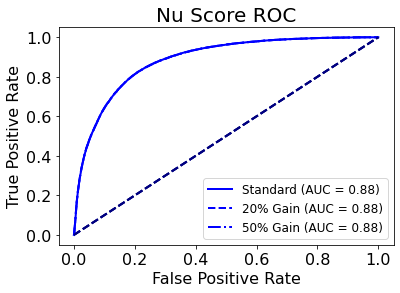

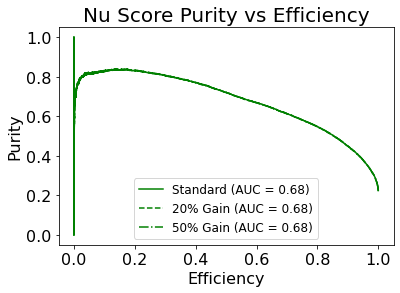

In [22]:
#Nu score ROC
weights = slc.data.genweight
scores = slc.data.nu_score
y = slc.data.truth.event_type
#For multiple samples
scores_v = [s.data.nu_score for s in slcs]
y_v = [s.data.truth.event_type for s in slcs]
weights_v = [s.data.genweight for s in slcs]

#ROC plot
fig,ax = make_roc_plot(y_v[0],scores_v[0],weights=weights_v[0],label=labels[0])
fig,ax = make_roc_plot(y_v[1],scores_v[1],ax=ax,fig=fig,weights=weights_v[1],label=labels[1],ls='--')
fig,ax = make_roc_plot(y_v[2],scores_v[2],title='Nu Score ROC',ax=ax,fig=fig,weights=weights_v[2],label=labels[2],ls='-.')
plotters.set_style(ax)
#plotters.add_label(ax, LABEL,where='centerright',color='grey',alpha=0.8)
if SAVE_PLOT:
    plotters.save_plot('nu_score',folder_name=f'{PLOT_DIR}',fig=fig)
    
#Purity vs Efficiency
fig,ax = make_pur_eff_plot(y_v[0],scores_v[0],weights=weights_v[0],label=labels[0])
fig,ax = make_pur_eff_plot(y_v[1],scores_v[1],ax=ax,fig=fig,weights=weights_v[1],label=labels[1],ls='--')
fig,ax = make_pur_eff_plot(y_v[2],scores_v[2],title='Nu Score Purity vs Efficiency',ax=ax,fig=fig,weights=weights_v[2],label=labels[2],ls='-.')
plotters.set_style(ax)
#plotters.add_label(ax, LABEL,where='bottomcenter',color='grey',alpha=0.8)
if SAVE_PLOT:
    plotters.save_plot('nu_score_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)
#Compare to other dataset

/tmp/ipykernel_33572/2366676025.py:4: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * (pur * eff) / (pur + eff)
/tmp/ipykernel_33572/2366676025.py:4: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * (pur * eff) / (pur + eff)
/tmp/ipykernel_33572/2366676025.py:4: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * (pur * eff) / (pur + eff)


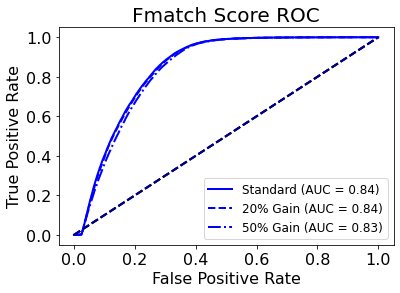

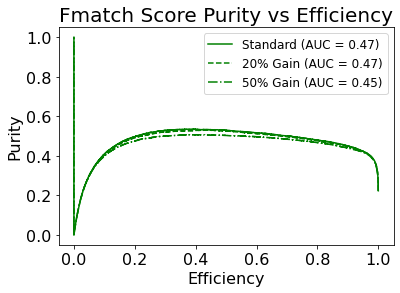

In [10]:
#simple fmatch score ROC
scores = -slc.data.fmatch.score
y = slc.data.truth.event_type
weights = slc.data.genweight
#For multiple samples
scores_v = [-s.data.fmatch.score for s in slcs]
y_v = [s.data.truth.event_type for s in slcs]
weights_v = [s.data.genweight for s in slcs]

#Roc plot
fig,ax = make_roc_plot(y_v[0],scores_v[0],weights=weights_v[0],label=labels[0])
fig,ax = make_roc_plot(y_v[1],scores_v[1],ax=ax,fig=fig,weights=weights_v[1],label=labels[1],ls='--')
fig,ax = make_roc_plot(y_v[2],scores_v[2],ax=ax,fig=fig,weights=weights_v[2],label=labels[2],ls='-.',title='Fmatch Score ROC')
#plotters.add_label(ax, LABEL,where='centerright',color='grey',alpha=0.8)
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('fmatch_score',folder_name=f'{PLOT_DIR}',fig=fig)

#Purity vs Efficiency
#fig,ax = make_pur_eff_plot(y,scores,pos_label=0,title='Fmatch Score Pur & Eff',weights=weights)
fig,ax = make_pur_eff_plot(y_v[0],scores_v[0],weights=weights_v[0],label=labels[0])
fig,ax = make_pur_eff_plot(y_v[1],scores_v[1],ax=ax,fig=fig,weights=weights_v[1],label=labels[1],ls='--')
fig,ax = make_pur_eff_plot(y_v[2],scores_v[2],ax=ax,fig=fig,weights=weights_v[2],label=labels[2],ls='-.',title='Fmatch Score Purity vs Efficiency')
plotters.set_style(ax)
#plotters.add_label(ax, LABEL,where='bottomcenter',color='grey',alpha=0.8)
if SAVE_PLOT:
    plotters.save_plot('fmatch_score_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)

NANs: 32825 , Non NANs: 169156


/tmp/ipykernel_1456426/2366676025.py:4: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (pur * eff) / (pur + eff)


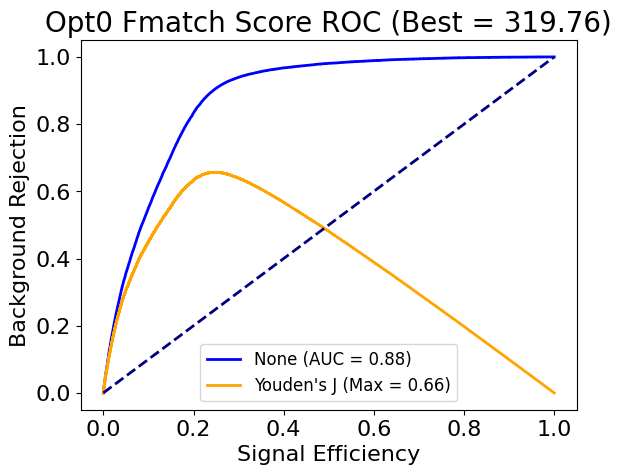

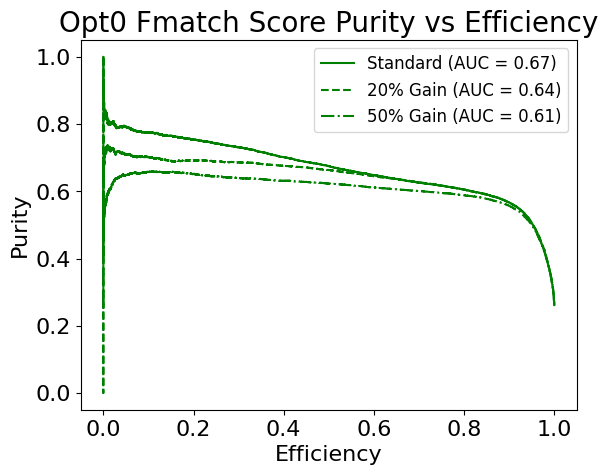

In [23]:
#Opt0 fmatch score ROC
scores = slc.data.opt0.score
print(f'NANs: {scores.isna().sum()} , Non NANs: {scores.notna().sum()}')
scores = scores[scores.notna()]
y = slc.data.truth.event_type
weights = slc.data.genweight
#For multiple samples
scores_v = [s.data.opt0.score for s in slcs]
mask_v = [s.data.opt0.score.notna() for s in slcs]
scores_v = [s[m] for m,s in zip(mask_v,scores_v)]
y_v = [s.data.truth.event_type[m] for m,s in zip(mask_v,slcs)]
weights_v = [s.data.genweight[m] for m,s in zip(mask_v,slcs)]

#Roc plot
fig,ax = make_roc_plot(y_v[0],scores_v[0],weights=weights_v[0],label=None,show_j=True,title='Opt0 Fmatch Score ROC')
#fig,ax = make_roc_plot(y_v[1],scores_v[1],ax=ax,fig=fig,weights=weights_v[1],label=labels[1],ls='--')
#fig,ax = make_roc_plot(y_v[2],scores_v[2],ax=ax,fig=fig,weights=weights_v[2],label=labels[2],ls='-.',title='Opt0 Fmatch Score ROC')
#plotters.add_label(ax, LABEL,where='centerright',color='grey',alpha=0.8)
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('opt0_fmatch_score',folder_name=f'{PLOT_DIR}',fig=fig)
    
#Purity vs Efficiency
#fig,ax = make_pur_eff_plot(y,scores,pos_label=0,title='Fmatch Score Pur & Eff',weights=weights)
fig,ax = make_pur_eff_plot(y_v[0],scores_v[0],weights=weights_v[0],label=labels[0])
fig,ax = make_pur_eff_plot(y_v[1],scores_v[1],ax=ax,fig=fig,weights=weights_v[1],label=labels[1],ls='--')
fig,ax = make_pur_eff_plot(y_v[2],scores_v[2],ax=ax,fig=fig,weights=weights_v[2],label=labels[2],ls='-.',title='Opt0 Fmatch Score Purity vs Efficiency')
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('opt0_fmatch_score_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)

### 2.2 FV
There's no good way to do this yet ..

In [12]:
_slc = slc.copy()
_slc.apply_cut('cosmic')

#For multiple samples
_slcs = [s.copy() for s in slcs]
[s.apply_cut('cosmic') for s in _slcs]


[None, None, None]

### 2.3 Track

In [13]:
_slc = slc.copy()
#apply cuts
_slc.apply_cut('cosmic')
_slc.apply_cut('fv')

#For multiple samples
_slcs = [s.copy() for s in slcs]
[s.apply_cut('cosmic') for s in _slcs]
[s.apply_cut('fv') for s in _slcs]

[None, None, None]

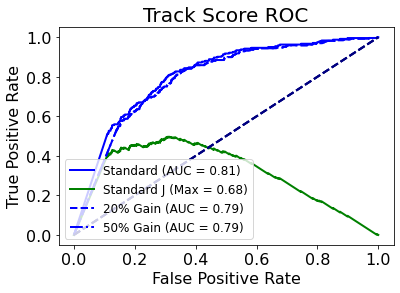

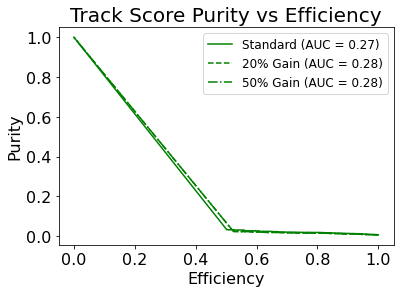

In [28]:
#Track score ROC
scores = -_slc.data.best_trk_score
y = _slc.data.truth.event_type
weights = _slc.data.genweight
#For multiple samples
scores_v = [-s.data.best_trk_score for s in _slcs]
y_v = [s.data.truth.event_type for s in _slcs]
weights_v = [s.data.genweight for s in _slcs]

#MAke ROC plot
#fig,ax = make_roc_plot(y,scores,weights=weights,title='Track Score ROC',show_f1=False,show_j=True)
fig,ax = make_roc_plot(y_v[0],scores_v[0],weights=weights_v[0],label=labels[0],pos_label=2,show_j=True)
fig,ax = make_roc_plot(y_v[1],scores_v[1],ax=ax,fig=fig,weights=weights_v[1],pos_label=2,label=labels[1],ls='--')
fig,ax = make_roc_plot(y_v[2],scores_v[2],ax=ax,fig=fig,weights=weights_v[2],pos_label=2,label=labels[2],ls='-.',title='Track Score ROC')
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('track_score',folder_name=f'{PLOT_DIR}',fig=fig)

#Purity vs Efficiency
#fig,ax = make_pur_eff_plot(y,scores,pos_label=0,title='Track Score Pur & Eff',weights=weights)
fig,ax = make_pur_eff_plot(y_v[0],scores_v[0],weights=weights_v[0],label=labels[0],pos_label=2)
fig,ax = make_pur_eff_plot(y_v[1],scores_v[1],ax=ax,fig=fig,weights=weights_v[1],pos_label=2,label=labels[1],ls='--')
fig,ax = make_pur_eff_plot(y_v[2],scores_v[2],ax=ax,fig=fig,weights=weights_v[2],pos_label=2,label=labels[2],ls='-.',title='Track Score Purity vs Efficiency')
plotters.set_style(ax)
#plotters.add_label(ax, LABEL,where='bottomcenter',color='grey',alpha=0.8)
#if SAVE_PLOT:
#    plotters.save_plot('track_score_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)
    

### 2.4 Muon

In [15]:
#This roc score has to be on the muons themselves
_pfp = pfp.copy()
_pfp.apply_cut(slc,'cosmic')
_pfp.apply_cut(slc,'fv')
_pfp.apply_cut(slc,'trk')

#For multiple samples
_pfps = [p.copy() for p in pfps]
[p.apply_cut(s,'cosmic') for p,s in zip(_pfps,slcs)]
[p.apply_cut(s,'fv') for p,s in zip(_pfps,slcs)]
[p.apply_cut(s,'trk') for p,s in zip(_pfps,slcs)]

[None, None, None]

NANs: 37974 , Non NANs: 107556


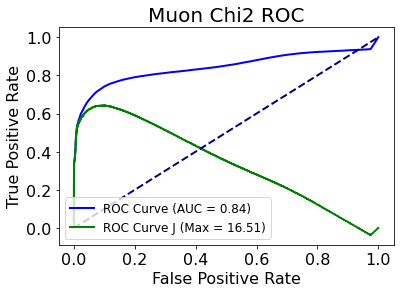

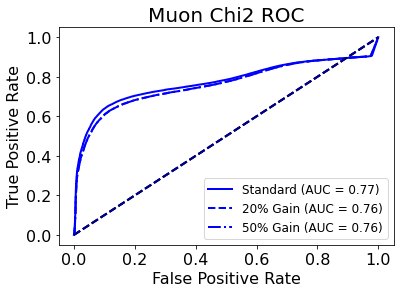

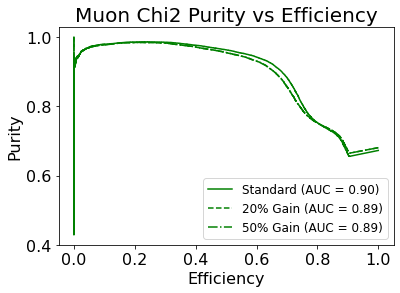

In [21]:
#Muon chi2 ROC
scores = _pfp.data.trk.chi2pid.I2.chi2_muon
print(f'NANs: {scores.isna().sum()} , Non NANs: {scores.notna().sum()}')
scores[scores.isna()] = 1e2 #fill in nan values to very large value
y = _pfp.data.trk.truth.p.pdg==13
weights = _pfp.data.genweight

#For multiple samples
scores_v = [p.data.trk.chi2pid.I2.chi2_muon for p in _pfps]
mask_v = [s.data.trk.chi2pid.I2.chi2_muon.notna() for s in _pfps]
scores_v = [s[m] for m,s in zip(mask_v,scores_v)]
y_v = [s.data.trk.truth.p.pdg[m]==13 for m,s in zip(mask_v,_pfps)]
weights_v = [s.data.genweight[m] for m,s in zip(mask_v,_pfps)]


#Make ROC
fig,ax = make_roc_plot(y,scores,weights=weights,title='Muon Chi2 ROC',show_j=True)
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('muon_chi2_show_j',folder_name=f'{PLOT_DIR}',fig=fig)
fig,ax = make_roc_plot(y_v[0],scores_v[0],weights=weights_v[0],label=labels[0])
fig,ax = make_roc_plot(y_v[1],scores_v[1],ax=ax,fig=fig,weights=weights_v[1],label=labels[1],ls='--')
fig,ax = make_roc_plot(y_v[2],scores_v[2],ax=ax,fig=fig,weights=weights_v[2],label=labels[2],ls='-.',title='Muon Chi2 ROC')
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('muon_chi2',folder_name=f'{PLOT_DIR}',fig=fig)

#Purity vs Efficiency
#fig,ax = make_pur_eff_plot(y,scores,pos_label=0,title='Muon Chi2 Pur & Eff',show_f1=True,weights=weights)
fig,ax = make_pur_eff_plot(y_v[0],scores_v[0],weights=weights_v[0],label=labels[0])
fig,ax = make_pur_eff_plot(y_v[1],scores_v[1],ax=ax,fig=fig,weights=weights_v[1],label=labels[1],ls='--')
fig,ax = make_pur_eff_plot(y_v[2],scores_v[2],ax=ax,fig=fig,weights=weights_v[2],label=labels[2],ls='-.',title='Muon Chi2 Purity vs Efficiency')
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('muon_chi2_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)


NANs: 37974 , Non NANs: 107556


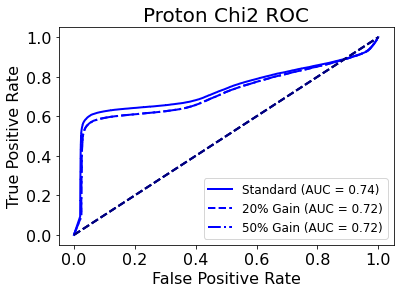

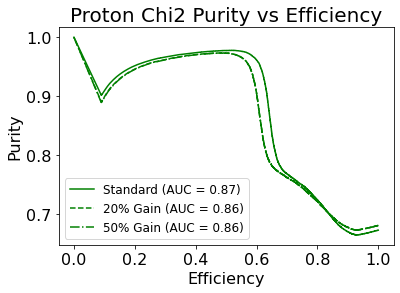

In [17]:
#Proton chi2 ROC
scores = -_pfp.data.trk.chi2pid.I2.chi2_proton
print(f'NANs: {scores.isna().sum()} , Non NANs: {scores.notna().sum()}')
scores[scores.isna()] = 0 #fill in nan values to small value
y = _pfp.data.trk.truth.p.pdg==13 #Still trying to match to muons
weights = _pfp.data.genweight

#For multiple samples
scores_v = [-p.data.trk.chi2pid.I2.chi2_proton for p in _pfps]
mask_v = [s.data.trk.chi2pid.I2.chi2_proton.notna() for s in _pfps]
scores_v = [s[m] for m,s in zip(mask_v,scores_v)]
y_v = [s.data.trk.truth.p.pdg[m]==13 for m,s in zip(mask_v,_pfps)]
weights_v = [s.data.genweight[m] for m,s in zip(mask_v,_pfps)]

#Make ROC
#fig,ax = make_roc_plot(y,scores,weights=weights,title='Proton Chi2 ROC',show_j=True)
fig,ax = make_roc_plot(y_v[0],scores_v[0],weights=weights_v[0],label=labels[0])
fig,ax = make_roc_plot(y_v[1],scores_v[1],ax=ax,fig=fig,weights=weights_v[1],label=labels[1],ls='--')
fig,ax = make_roc_plot(y_v[2],scores_v[2],ax=ax,fig=fig,weights=weights_v[2],label=labels[2],ls='-.',title='Proton Chi2 ROC')
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('proton_chi2',folder_name=f'{PLOT_DIR}',fig=fig)

#Purity vs Efficiency
#fig,ax = make_pur_eff_plot(y,scores,pos_label=0,title='Proton Chi2 Pur & Eff',weights=weights)
fig,ax = make_pur_eff_plot(y_v[0],scores_v[0],weights=weights_v[0],label=labels[0])
fig,ax = make_pur_eff_plot(y_v[1],scores_v[1],ax=ax,fig=fig,weights=weights_v[1],label=labels[1],ls='--')
fig,ax = make_pur_eff_plot(y_v[2],scores_v[2],ax=ax,fig=fig,weights=weights_v[2],label=labels[2],ls='-.',title='Proton Chi2 Purity vs Efficiency')
plotters.set_style(ax)

if SAVE_PLOT:
    plotters.save_plot('proton_chi2_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)


NANs: 68997 , Non NANs: 76533


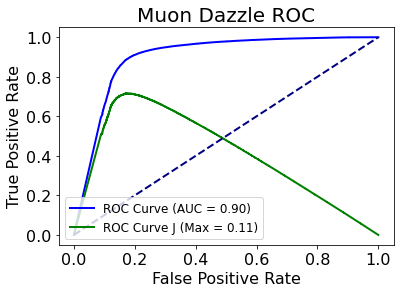

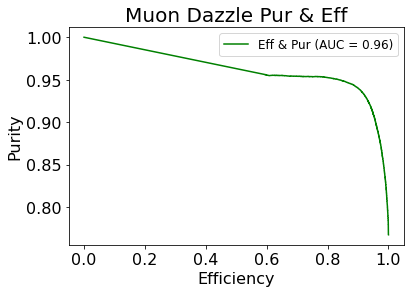

In [18]:
#Muon dazzle
scores = -_pfp.data.trk.dazzle.muonScore
print(f'NANs: {scores.isna().sum()} , Non NANs: {scores.notna().sum()}')
scores[scores.isna()] = 0 #fill in nan values to small value
y = _pfp.data.trk.truth.p.pdg==13 #Still trying to match to muons
weights = _pfp.data.genweight

#For multiple samples
scores_v = [-p.data.trk.dazzle.muonScore for p in _pfps]
mask_v = [s.data.trk.dazzle.muonScore.notna() for s in _pfps]
scores_v = [s[m] for m,s in zip(mask_v,scores_v)]
y_v = [s.data.trk.truth.p.pdg[m]==13 for m,s in zip(mask_v,_pfps)]                      
weights_v = [s.data.genweight[m] for m,s in zip(mask_v,_pfps)]

#Make ROC
fig,ax = make_roc_plot(y,scores,weights=weights,title='Muon Dazzle ROC',show_j=True)
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('muon_dazzle_show_j',folder_name=f'{PLOT_DIR}',fig=fig)

#Purity vs Efficiency
fig,ax = make_pur_eff_plot(y,scores,pos_label=0,title='Muon Dazzle Pur & Eff',weights=weights)
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('muon_dazzle_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)

NANs: 37974 , Non NANs: 107556


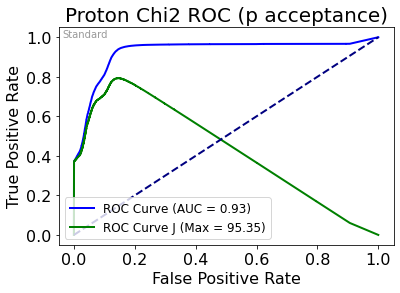

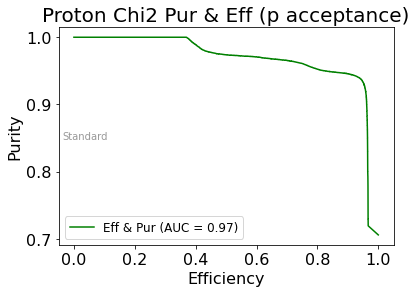

In [19]:
#Proton chi2 ROC
scores = _pfp.data.trk.chi2pid.I2.chi2_proton
print(f'NANs: {scores.isna().sum()} , Non NANs: {scores.notna().sum()}')
scores[scores.isna()] = 1e4 #fill in nan values to small value
y = _pfp.data.trk.truth.p.pdg==2212 #Still trying to match to muons
weights = _pfp.data.genweight
df = pd.concat([scores,y],axis=1)
#save into data_dir
df.to_csv(f'{DATA_DIR}/roc_scores/{FNAME[:-3]}_proton_proton_chi2.csv')

#Make ROC
fig,ax = make_roc_plot(y,scores,weights=weights,title='Proton Chi2 ROC (p acceptance)',show_j=True)
plotters.add_label(ax, LABEL,where='topleft',color='grey',alpha=0.8)
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('proton_proton_chi2_showj',folder_name=f'{PLOT_DIR}',fig=fig)
    
#Purity vs Efficiency
fig,ax = make_pur_eff_plot(y,scores,pos_label=0,title='Proton Chi2 Pur & Eff (p acceptance)',weights=weights)
plotters.set_style(ax)
plotters.add_label(ax, LABEL,where='centerleft',color='grey',alpha=0.8)
if SAVE_PLOT:
    plotters.save_plot('proton_proton_chi2_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)

NANs: 37974 , Non NANs: 107556


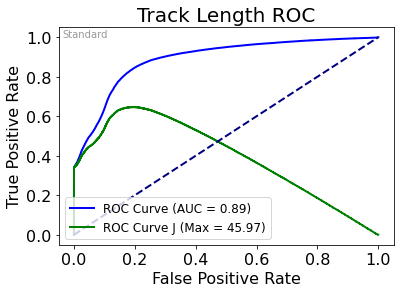

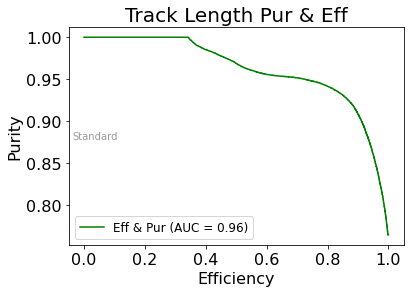

In [20]:
# Track length ROC
scores = -_pfp.data.trk.len
print(f'NANs: {scores.isna().sum()} , Non NANs: {scores.notna().sum()}')
scores[scores.isna()] = 0 #fill in nan values to small value
y = _pfp.data.trk.truth.p.pdg==13
weights = _pfp.data.genweight
df = pd.concat([scores,y],axis=1)
#save into data_dir
df.to_csv(f'{DATA_DIR}/roc_scores/{FNAME[:-3]}_track_len.csv')

#Make ROC
fig,ax = make_roc_plot(y,scores,weights=weights,title='Track Length ROC',show_j=True)
plotters.add_label(ax, LABEL,where='topleft',color='grey',alpha=0.8)
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('track_len',folder_name=f'{PLOT_DIR}',fig=fig)

#Purity vs Efficiency
fig,ax = make_pur_eff_plot(y,scores,pos_label=0,title='Track Length Pur & Eff',weights=weights)
plotters.set_style(ax)
plotters.add_label(ax, LABEL,where='centerleft',color='grey',alpha=0.8)
if SAVE_PLOT:
    plotters.save_plot('track_len_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)
